In [5]:
from PIL import Image
import depth_pro 
import torch 
import numpy as np  
import cv2 
import matplotlib.pyplot as plt
import requests 


In [2]:
model, transform = depth_pro.create_model_and_transforms()
model.eval() 
model.to("cuda") 

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [7]:
image, _, f_px = depth_pro.load_rgb(r"C:\Users\BiswanathSaha\Downloads\test.jpg") 
image = transform(image)

In [8]:
# Run inference.
prediction = model.infer(image.to("cuda"), f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels. 

In [9]:
##Remove background  
depth_np = depth.detach().cpu().numpy() 
f_length = focallength_px.detach().cpu().numpy()   
disparity = f_length / depth_np 
disp_norm = (disparity - np.min(disparity)) / (np.max(disparity) - np.min(disparity))  

In [10]:
disp_thresh = 0.411 #bound to [0,1]
mask = (disp_norm > disp_thresh).astype(np.uint8) * 255
print(mask.shape)

(1500, 1000)


In [11]:
# Optional: Apply some morphological operations to refine the mask
kernel = np.ones((5,5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  

In [12]:
# Convert image tensor to numpy array (assuming it's in CHW format)
image_np = image.permute(1, 2, 0).cpu().numpy()

# Normalize image to 0-255 range
image_np = ((image_np - image_np.min()) / (image_np.max() - image_np.min()) * 255).astype(np.uint8)

# Apply mask to remove background
result = cv2.bitwise_and(image_np, image_np, mask=mask) 

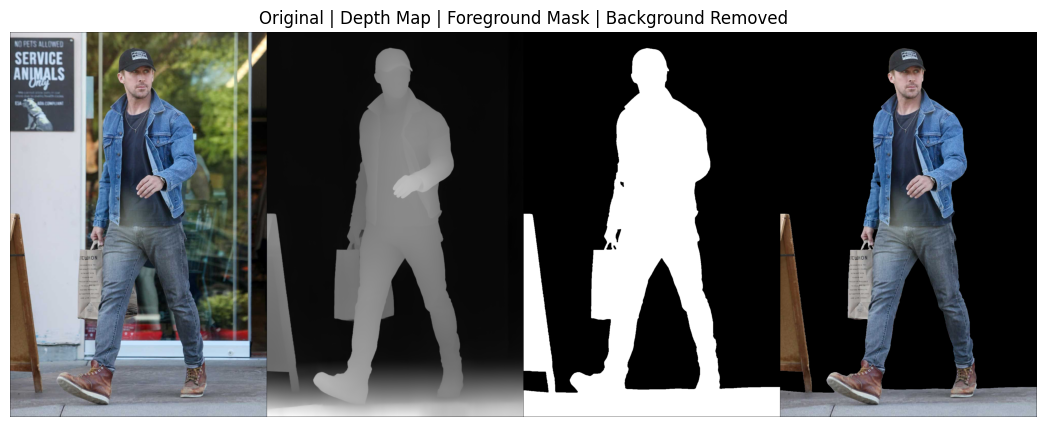

In [24]:
from torchvision.utils import make_grid  
# Convert numpy arrays to PyTorch tensors
image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0
disp_norm_tensor = torch.from_numpy(disp_norm).unsqueeze(0).float()
mask_tensor = torch.from_numpy(mask).unsqueeze(0).float() / 255.0
result_tensor = torch.from_numpy(result).permute(2, 0, 1).float() / 255.0

# Create a grid of images
grid = make_grid([image_tensor, disp_norm_tensor.repeat(3, 1, 1), 
                  mask_tensor.repeat(3, 1, 1), result_tensor], 
                 nrow=4, padding=1, normalize=False)

# Display the grid
plt.figure(figsize=(20, 5),frameon=False)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Original | Depth Map | Foreground Mask | Background Removed')
plt.savefig("bg_remove.png",dpi=600,format="png")
plt.show();